In [429]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification

In [430]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

In [ ]:
""" X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res)) """

In [431]:
train_x=train.drop(['credit','index'], axis=1)
train_y=train[['credit']]
test_x=test.drop('index', axis =1)

# Feature 설명

index   
gender: 성별   
car: 차량 소유 여부   
reality: 부동산 소유 여부   
child_num: 자녀 수   
income_total: 연간 소득  
income_type: 소득 분류 
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   
edu_type: 교육 수준   
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   
family_type: 결혼 여부   
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   
house_type: 생활 방식   
['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   
DAYS_BIRTH: 출생일   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
DAYS_EMPLOYED: 업무 시작일   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   
FLAG_MOBIL: 핸드폰 소유 여부  
work_phone: 업무용 전화 소유 여부   
phone: 전화 소유 여부  
email: 이메일 소유 여부   
occyp_type: 직업 유형	   												
family_size: 가족 규모  
begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   



# DEF 모음

In [433]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

# **DROP_DATA**

In [434]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n)  for i,j,k,l,m,n in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'],train['begin_month'])]
test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n) for i,j,k,l,m,n in zip(test['gender'],test['income_total'],test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'],test['begin_month'])]

In [435]:
subset = train['identity'].value_counts() > 1
subset

F112500.0Working-13686-1256-2.0                  True
F315000.0Working-13064-2286-33.0                 True
F135000.0Pensioner-20752365243-23.0              True
M270000.0Working-16896-248-1.0                   True
F135000.0Working-8319-689-10.0                   True
                                                ...  
M225000.0State servant-15108-211-19.0           False
F247500.0Working-19852-200-34.0                 False
F121500.0State servant-19988-3231-41.0          False
F135000.0Commercial associate-19124-670-32.0    False
M405000.0State servant-17309-3500-16.0          False
Name: identity, Length: 24098, dtype: bool

In [436]:
drop_list = []

for i in range(len(subset)):
    if subset.values[i] == True:
        drop_list.append(subset.index[i])
    else:
        pass

In [437]:
for i in tqdm(range(len(drop_list))):
    train = train.drop(index = train.loc[train['identity'] == drop_list[i]].sort_values(by=['begin_month']).index[1:] , axis=0)

100%|██████████| 2150/2150 [00:18<00:00, 117.82it/s]


In [438]:
train.shape

(24098, 21)

In [439]:
train = train.drop('identity', axis = 1)
test = test.drop('identity', axis = 1)

# **Preprocessing**

## **0. FLAG_MOBIL**

In [440]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'] - train['work_phone']*0.3 - train['phone']*0.3 - train['email']*0.3
test['FLAG_MOBIL'] = test['FLAG_MOBIL'] - test['work_phone']*0.3 - test['phone']*0.3 - test['email']*0.3

In [441]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])

In [442]:
train['FLAG_MOBIL'].value_counts()

A    13253
B     7254
C     3341
D      250
Name: FLAG_MOBIL, dtype: int64

In [443]:
test['FLAG_MOBIL'].value_counts()

A    5502
B    2984
C    1431
D      83
Name: FLAG_MOBIL, dtype: int64

## **1. DAYS_EMPLOYED**

In [444]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

365243    4059
Name: DAYS_EMPLOYED, dtype: int64

In [445]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

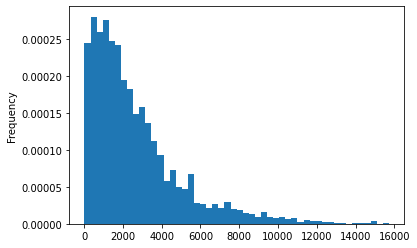

In [446]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [447]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 24098, dtype: int64

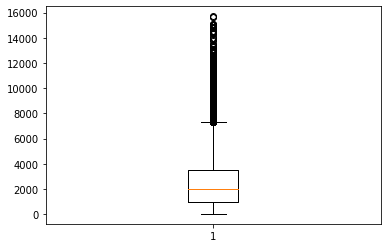

In [448]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [449]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.0 Q3 : 3505.0 IQR : 2536.0


In [450]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3
test.loc[(test['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (test['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

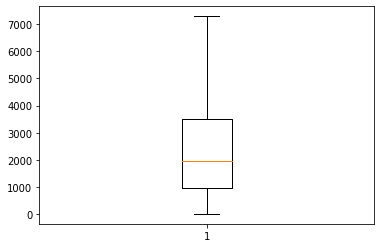

In [451]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [452]:
train['DAYS_EMPLOYED'].value_counts()

0.0       4059
3505.0    1158
401.0       53
1539.0      42
2087.0      39
          ... 
2582.0       1
5404.0       1
6372.0       1
1452.0       1
233.0        1
Name: DAYS_EMPLOYED, Length: 3121, dtype: int64

## **Begin_month**

<AxesSubplot:ylabel='Frequency'>

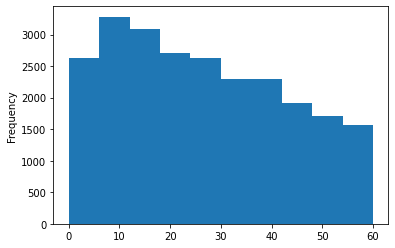

In [453]:
abs(train['begin_month']).plot(kind='hist', bins = 10)

In [454]:
train['begin_month'] = train['begin_month'].abs()
test['begin_month'] = test['begin_month'].abs()

In [455]:
train['begin_month'].value_counts()

7.0     599
3.0     547
6.0     545
5.0     545
11.0    544
       ... 
56.0    223
59.0    215
0.0     214
60.0    210
57.0    208
Name: begin_month, Length: 61, dtype: int64

## **income_total**

<AxesSubplot:ylabel='Frequency'>

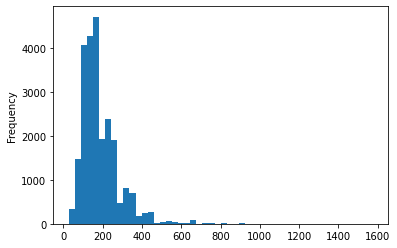

In [456]:
(train['income_total']/1000).plot(kind = 'hist', bins = 50)

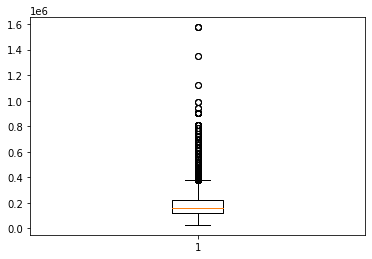

In [457]:
plt.boxplot(train['income_total'])
plt.show()

In [458]:
Q1 = box_value('income_total')[0]
Q2 = box_value('income_total')[1]
Q3 = box_value('income_total')[2]
IQR = box_value('income_total')[3]

In [459]:
train.loc[(train['income_total'] <= Q1 - 1.5 * IQR) | (train['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3
test.loc[(test['income_total'] <= Q1 - 1.5 * IQR) | (test['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3

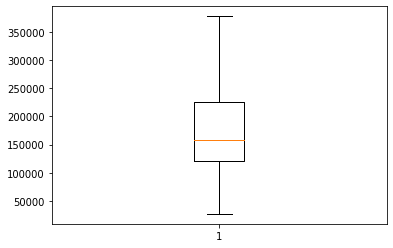

In [460]:
plt.boxplot(train['income_total'])
plt.show()

In [461]:
train['income_total'].value_counts()

135000.0    2869
157500.0    2067
180000.0    2035
112500.0    1993
225000.0    1945
            ... 
249750.0       1
91530.0        1
179271.0       1
99900.0        1
44550.0        1
Name: income_total, Length: 203, dtype: int64

## Gender, Car, Reality

In [462]:
""" train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------') """

" train['gender'] = train['gender'].replace(['F','M'],[0,1])\ntest['gender'] = test['gender'].replace(['F','M'],[0,1])\nprint('gender :')\nprint(train['gender'].value_counts())\nprint('--------------')\n\nprint('Having a car or not : ')\ntrain['car'] = train['car'].replace(['N','Y'],[0,1])\ntest['car'] = test['car'].replace(['N','Y'],[0,1])\nprint(train['car'].value_counts())\nprint('--------------')\n\nprint('Having house reality or not: ')\ntrain['reality'] = train['reality'].replace(['N','Y'],[0,1])\ntest['reality'] = test['reality'].replace(['N','Y'],[0,1])\nprint(train['reality'].value_counts())\nprint('--------------') "

## DAYS_BIRTH

In [463]:
train['DAYS_BIRTH'] = (train['DAYS_BIRTH'].abs()/365).astype(int)
test['DAYS_BIRTH'] = (test['DAYS_BIRTH'].abs()/365).astype(int)

<AxesSubplot:ylabel='Frequency'>

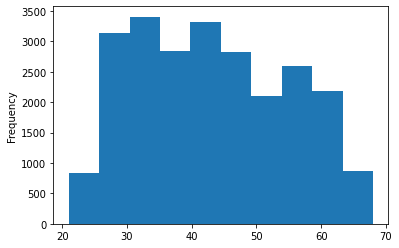

In [464]:
train['DAYS_BIRTH'].plot(kind='hist')

In [465]:
train['DAYS_BIRTH'].value_counts()

37    825
27    752
40    739
28    737
34    718
39    716
32    709
41    683
33    679
35    668
38    667
30    665
42    661
43    639
36    634
31    632
46    616
29    614
47    607
44    604
48    569
54    568
51    567
57    554
50    541
45    534
60    531
59    526
56    522
58    509
53    502
49    493
52    491
55    437
62    406
63    368
26    363
64    362
61    356
25    316
24    259
65    220
66    181
23    152
22    102
67     77
68     22
21      5
Name: DAYS_BIRTH, dtype: int64

## **family_size**

In [466]:
train['family_size'].value_counts()

2.0     12840
1.0      4631
3.0      4234
4.0      2074
5.0       266
6.0        38
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [467]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [468]:
train['family_size'] = train['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)
test['family_size'] = test['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)

In [469]:
train['family_size'] = train['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})
test['family_size'] = test['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})

In [470]:
train['family_size'].value_counts()

B    12840
A     4631
C     4234
D     2393
Name: family_size, dtype: int64

## **work_phone**, **phone**, **email**, **FLAG_MOBIL**

In [471]:
train['work_phone'] = train['work_phone'].replace([0,1], ['N','Y'])
test['work_phone'] = test['work_phone'].replace([0,1], ['N','Y'])

train['phone'] = train['phone'].replace([0,1], ['N','Y'])
test['phone'] = test['phone'].replace([0,1], ['N','Y'])


train['email'] = train['email'].replace([0,1], ['N','Y'])
test['email'] = test['email'].replace([0,1], ['N','Y'])


## **child_num**

In [472]:
train['child_num'].value_counts()

0     16659
1      4935
2      2167
3       280
4        41
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [473]:
test['child_num'].value_counts()

0    6861
1    2106
2     894
3     113
4      16
5      10
Name: child_num, dtype: int64

In [474]:
def child_category(value):
    ep = ''
    if value == 0: ep = 'A'
    elif value == 1: ep = 'B'
    elif value == 2: ep = 'C'
    elif value >= 3: ep = 'D'
    
    return ep

In [475]:
train['child_num'] = train['child_num'].apply(lambda x : child_category(x))
test['child_num'] = test['child_num'].apply(lambda x : child_category(x))

In [476]:
train['child_num'].value_counts()

A    16659
B     4935
C     2167
D      337
Name: child_num, dtype: int64

## **occyp_type**

In [477]:
from sklearn.cluster import KMeans

train['occyp_type'] = train['occyp_type'].fillna('Secret')
test['occyp_type'] = test['occyp_type'].fillna('Secret')

subset = pd.crosstab(train['occyp_type'] , train['income_total'])
subset['Total'] = subset.sum(axis=1)

subset = subset.div(subset['Total'].values, axis = 0)
subset = subset.drop('Total', axis = 1)
subset = subset.drop('Secret', axis = 0)

kmeans = KMeans(n_clusters= 3)
kmeans.fit(subset)

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0])

In [478]:
subset['cluster'] = kmeans.labels_
subset

income_total,27000.0,29250.0,30150.0,31500.0,31531.5,32400.0,33300.0,33750.0,36000.0,36900.0,...,346500.0,351000.0,355500.0,360000.0,360450.0,364500.0,369000.0,373500.0,378000.0,cluster
occyp_type,,,,,,,,,,,,,,,,,,,,,
Accountants,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.029520,0.0,0.000000,0.000000,0.006150,0.000000,0
Cleaning staff,0.000000,0.0,0.0,0.010695,0.0,0.000000,0.0,0.0,0.002674,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
Cooking staff,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.021531,0.0,0.000000,0.000000,0.000000,0.000000,0
Core staff,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000413,0.000000,...,0.00000,0.000000,0.002066,0.014876,0.0,0.000000,0.000000,0.002066,0.000000,0
Drivers,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.033126,0.0,0.000000,0.002070,0.000000,0.000000,0
HR staff,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
High skill tech staff,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.022129,0.0,0.000000,0.000000,0.000000,0.000000,0
IT staff,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
Laborers,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000485,0.000485,...,0.00097,0.000243,0.000000,0.011885,0.0,0.000485,0.000000,0.000000,0.000000,0


In [479]:
subset[subset['cluster']== 0].index

Index(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
       'Drivers', 'HR staff', 'High skill tech staff', 'IT staff', 'Laborers',
       'Managers', 'Medicine staff', 'Private service staff', 'Sales staff',
       'Secretaries', 'Security staff', 'Waiters/barmen staff'],
      dtype='object', name='occyp_type')

In [480]:
train['occyp_type'] = train['occyp_type'].replace('Secret' , 'A')
train['occyp_type'] = train['occyp_type'].replace(['Accountants', 'Core staff', 'Drivers', 'HR staff','High skill tech staff', 'IT staff', 'Laborers','Private service staff', 'Sales staff', 'Security staff'],
 'B')
train['occyp_type'] = train['occyp_type'].replace(['Cooking staff', 'Cleaning staff','Low-skill Laborers', 'Medicine staff', 'Secretaries','Waiters/barmen staff'], 'C')
train['occyp_type'] = train['occyp_type'].replace(['Realty agents','Managers'], 'D')

In [481]:
test['occyp_type'] = test['occyp_type'].replace('Secret' , 'A')
test['occyp_type'] = test['occyp_type'].replace(['Accountants', 'Core staff', 'Drivers', 'HR staff','High skill tech staff', 'IT staff', 'Laborers','Private service staff', 'Sales staff', 'Security staff'],
 'B')
test['occyp_type'] = test['occyp_type'].replace(['Cooking staff', 'Cleaning staff','Low-skill Laborers', 'Medicine staff', 'Secretaries','Waiters/barmen staff'], 'C')
test['occyp_type'] = test['occyp_type'].replace(['Realty agents','Managers'], 'D')

In [482]:
train['occyp_type'].value_counts()

B    12768
A     7415
D     2008
C     1907
Name: occyp_type, dtype: int64

In [483]:
test['occyp_type'].value_counts()

B    5146
A    3152
D     861
C     841
Name: occyp_type, dtype: int64

In [484]:
train.to_csv('train_2.csv')
test.to_csv('test_2.csv')

## **중간시작**

In [485]:
train = pd.read_csv('train_2.csv', index_col = 'Unnamed: 0')
test = pd.read_csv('test_2.csv', index_col = 'Unnamed: 0')

# **ENCODING**

In [486]:
encoder = OrdinalEncoder()
encoder.fit(train_x[['child_num','family_size','child_num','family_size']])

train_x[['child_num','family_size','child_num','family_size']] = encoder.transform(train_x[['child_num','family_size','child_num','family_size']])
encoder.categories_

[array([ 0,  1,  2,  3,  4,  5,  7, 14, 19], dtype=int64),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 15., 20.]),
 array([ 0,  1,  2,  3,  4,  5,  7, 14, 19], dtype=int64),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 15., 20.])]

In [487]:
encoder.fit(test_x[['child_num','family_size','child_num','family_size']])

test_x[['child_num','family_size','child_num','family_size']] = encoder.transform(test_x[['child_num','family_size','child_num','family_size']])
encoder.categories_

[array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([1., 2., 3., 4., 5., 6., 7.]),
 array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([1., 2., 3., 4., 5., 6., 7.])]

In [488]:
train_x = pd.get_dummies(train_x,drop_first= True)
test_x = pd.get_dummies(test_x,drop_first= True)

In [490]:
# 모델설정
sm = SMOTE()

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_resample(train_x,train_y)

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

After OverSampling, the shape of train_X: (50904, 47)
After OverSampling, the shape of train_y: (50904, 47) 



In [411]:
train_x

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,gender_M,car_Y,reality_Y,income_type_Pensioner,...,house_type_With parents,FLAG_MOBIL_B,FLAG_MOBIL_C,FLAG_MOBIL_D,work_phone_Y,phone_Y,email_Y,occyp_type_B,occyp_type_C,occyp_type_D
0,0.0,202500.0,38,4709.0,1.0,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,247500.0,31,1540.0,2.0,5.0,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0
2,0.0,259500.0,52,4434.0,1.0,22.0,1,1,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0.0,202500.0,41,2092.0,1.0,37.0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
4,0.0,157500.0,41,2105.0,1.0,26.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2.0,225000.0,33,1984.0,3.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26453,1.0,180000.0,41,2475.0,1.0,47.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
26454,0.0,292500.0,27,2015.0,1.0,25.0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
26455,0.0,171000.0,27,107.0,0.0,59.0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [412]:
print(train_x.shape, test_x.shape, train_y.shape)

(24098, 35) (10000, 35) (24098, 1)


## 모델링

In [491]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, 
                                                    stratify=y_resampled, test_size=0.25,
                                                    random_state = 2021)

""" print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


ada_pred=AdaBoostClassifier()
ada_pred.fit(X_train, y_train)
y_pred=ada_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}") """

' print("Train set: ")\nprint(X_train.shape)\nprint(y_train.shape)\nprint("===========")\nprint("Validation set: ")\nprint(X_val.shape)\nprint(y_val.shape)\n\n\nada_pred=AdaBoostClassifier()\nada_pred.fit(X_train, y_train)\ny_pred=ada_pred.predict_proba(X_val)\n\nprint(f"log_loss: {log_loss(to_categorical(y_val[\'credit\']), y_pred)}") '

In [493]:
rf_pred=RandomForestClassifier(random_state=2021)
rf_pred.fit(X_train, y_train)
y_pred=rf_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.7829754631597532


In [494]:
gb_pred=GradientBoostingClassifier(random_state=2021)
gb_pred.fit(X_train, y_train)
y_pred=gb_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.9102720385541272


In [495]:
cat_pred=CatBoostClassifier(random_state=2021, learning_rate = 0.11, iterations = 530)
cat_pred.fit(X_train, y_train, silent= True)
y_pred=cat_pred.predict(X_train)
#print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

0.8080131971966189

In [505]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(X_resampled, y_resampled)):
        X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
        y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
        clf.fit(X_train, y_train,silent= True)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_pred)

FOLD 0 : logloss:0.711500104192183
FOLD 1 : logloss:0.7074068022413057
FOLD 2 : logloss:0.7132141312455581
FOLD 3 : logloss:0.7095407803983578
FOLD 4 : logloss:0.7098502581064593
Mean:0.7103024152367727


In [506]:
submission.loc[:,1:]=my_submission

In [507]:
submission

,index,0,1,2
0,26457,0.097412,0.148409,0.754179
1,26458,0.258202,0.115588,0.626210
2,26459,0.172058,0.158030,0.669912
3,26460,0.265100,0.209635,0.525265
4,26461,0.069415,0.154702,0.775883
...,...,...,...,...
9995,36452,0.248174,0.302471,0.449355
9996,36453,0.194037,0.334853,0.471110
9997,36454,0.029952,0.090093,0.879955
9998,36455,0.221651,0.273075,0.505274


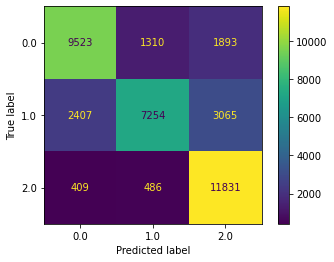

In [508]:
plot_confusion_matrix(cat_pred, X_train, y_train)
plt.show()

In [509]:
confusion_matrix(y_train, y_pred)

array([[ 9658,  1299,  1769],
       [ 2453,  7342,  2931],
       [  394,   440, 11892]], dtype=int64)

In [510]:
accuracy_score(y_train, y_pred)

0.7567709151867568

In [511]:
submission.to_csv('../Data/Oversampling.csv', index=False)

In [80]:
cat_pred.get_params()

{'iterations': 530, 'learning_rate': 0.11, 'random_state': 2021}

In [84]:
print(X_train.shape)

(19842, 44)


In [79]:
cat_pred.get_feature_importance()

array([4.06597571, 4.71833933, 4.35677557, 1.33638137, 0.94379377,
       1.13664565, 3.13742471, 3.16678812, 2.88036481, 1.18795181,
       1.45082143, 0.00697603, 3.77077781, 3.24948439, 0.8262354 ,
       0.2036988 , 2.40280683, 2.47763994, 0.99620369, 1.6679202 ,
       0.63944587, 1.00134083, 0.598371  , 0.12821469, 0.38328804,
       0.78881015, 2.86821181, 3.43332387, 1.87359181, 0.66341199,
       2.42040787, 2.51383688, 2.62246706, 1.62264169, 3.33068855,
       4.73728831, 1.91878463, 1.82483588, 1.44870369, 1.10917936,
       5.25923316, 4.97255214, 4.53129466, 5.3270707 ])

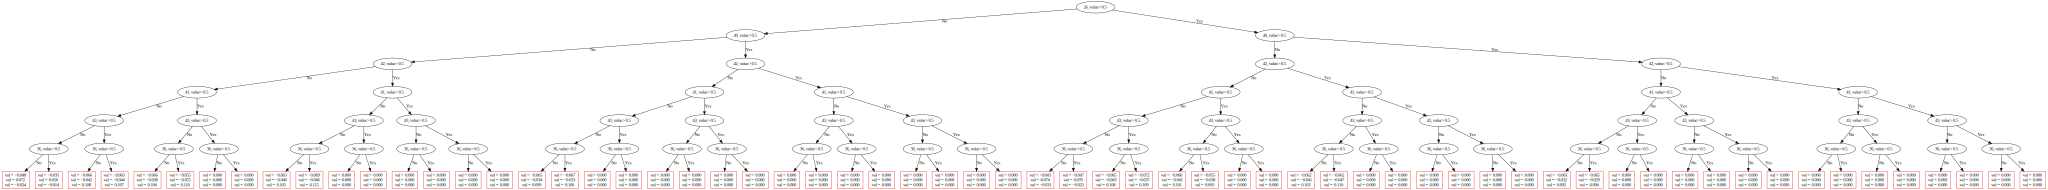

In [83]:
cat_pred.plot_tree(tree_idx = 1, pool=None)